# 1. 单层网络

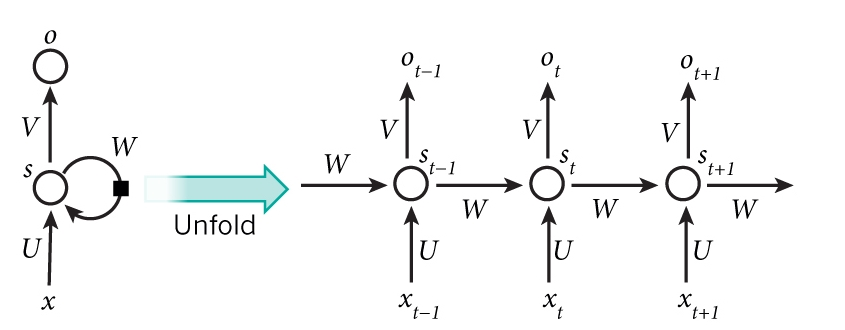

TF-API版本变动（https://github.com/tensorflow/tensorflow/issues/27023）

## 函数接口

## 1.1 RNN

#num_units为隐藏层神经元的个数

BasicRNNCell: tf.nn.rnn_cell.BasicRNNCell(num_units)

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

batch_size = 1
max_seq=6
word_dim=3
tf.reset_default_graph()
input = tf.random_normal(shape=[batch_size,max_seq, word_dim], dtype=tf.float32)
cell = tf.nn.rnn_cell.BasicRNNCell(num_units=10)#tf.nn.rnn_cell.BasicRNNCell(10)
init_state = cell.zero_state(batch_size, dtype=tf.float32)
# dynamic_rnn内部用tf.While循环动态创建图，善于处理变长序列
output, final_state = tf.nn.dynamic_rnn(cell, input, initial_state=init_state)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    out,fstate=sess.run([output,final_state])
    print(out.shape)
    print(fstate.shape) #[batch_size, cell.state_size]

(1, 6, 10)
(1, 10)


## 1.2 LSTM

#num_units为隐藏层神经元的个数

BasicLSTMCell: tf.nn.rnn_cell.BasicLSTMCell(num_units)

In [2]:
import os
import tensorflow as tf
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

batch_size = 8
max_seq=6
dim=3
tf.reset_default_graph()
input = tf.random_normal(shape=[batch_size,max_seq, dim], dtype=tf.float32)
cell = tf.nn.rnn_cell.BasicLSTMCell(10)
init_state = cell.zero_state(batch_size, dtype=tf.float32)
# dynamic_rnn内部用tf.While循环动态创建图，善于处理变长序列
output, final_state = tf.nn.dynamic_rnn(cell, input, initial_state=init_state)
c,h=final_state
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print(sess.run(output).shape) # [batch_size, max_seq, cell.output_size]
    print(sess.run(c).shape) #[batch_size, cell.state_size]
    print(sess.run(h).shape) #[batch_size, cell.state_size]

(8, 6, 10)
(8, 10)
(8, 10)


## 1.3 GRU

#num_units为隐藏层神经元的个数

GRUCell: tf.nn.rnn_cell.GRUCell(num_units)

In [3]:
tf.reset_default_graph()
batch_size = 8
max_seq=6
dim=3
input = tf.random_normal(shape=[batch_size,max_seq, dim], dtype=tf.float32)
cell = tf.nn.rnn_cell.GRUCell(10)
init_state = cell.zero_state(batch_size, dtype=tf.float32)
# dynamic_rnn内部用tf.While循环动态创建图，善于处理变长序列
output, final_state = tf.nn.dynamic_rnn(cell, input, initial_state=init_state)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print(sess.run(output).shape) # [batch_size, max_seq, cell.output_size]
    print(sess.run(final_state).shape) #[batch_size, cell.state_size]

(8, 6, 10)
(8, 10)


# 2. 多层网络

单层RNN的能力有限，我们需要多层的RNN。将x输入第一层RNN的后得到隐层状态h，这个隐层状态就相当于第二层RNN的输入，第二层RNN的隐层状态又相当于第三层RNN的输入，以此类推。

In [4]:
import tensorflow as tf
import numpy as np

tf.reset_default_graph()
batch_size=8
max_seq=6
word_dim=3
hidden_size=128
num_layers=3
inputs = tf.random_normal(shape=[batch_size,max_seq, word_dim], dtype=tf.float32)

# 每调用一次这个函数就返回一个BasicRNNCell
def get_a_cell():
    return tf.nn.rnn_cell.BasicRNNCell(num_units=hidden_size)

# 用tf.nn.rnn_cell MultiRNNCell创建3层RNN
cells = tf.nn.rnn_cell.MultiRNNCell([get_a_cell() for _ in range(num_layers)]) # 3层RNN
# 得到的cell实际也是RNNCell的子类,它的state_size是(128, 128, 128)
# (128, 128, 128)并不是128x128x128的意思，而是表示共有3个隐层状态，每个隐层状态的大小为128
print(cells.state_size) # (128, 128, 128)

input = tf.random_normal(shape=[batch_size,max_seq, word_dim], dtype=tf.float32)
output, final_state = tf.nn.dynamic_rnn(cells, input, dtype=tf.float32)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print(sess.run(output).shape) # [batch_size, max_seq, cell.output_size]
    print(sess.run(final_state)[0].shape) #[batch_size, cell.state_size]
    print(sess.run(final_state)[1].shape) #[batch_size, cell.state_size]
    print(sess.run(final_state)[2].shape) #[batch_size, cell.state_size]

(128, 128, 128)
(8, 6, 128)
(8, 128)
(8, 128)
(8, 128)


# 3. 双向网络

双向RNN模型是RNN的扩展模型，RNN模型在处理序列模型的学习上主要依靠上文的信息，双向RNN模型认为模型的输出不仅仅依靠序列前面的元素，后面的元素对输出也有影响。比如说，想要预测序列中的一个缺失值，我们不仅仅要考虑该缺失值前面的元素，而且要考虑后面的元素。

简单点就是将两个RNN堆叠在一起，分别从两个方向计算序列的output和state，而最终的输出则根据两个RNNs的隐藏状态计算，如下图所示：

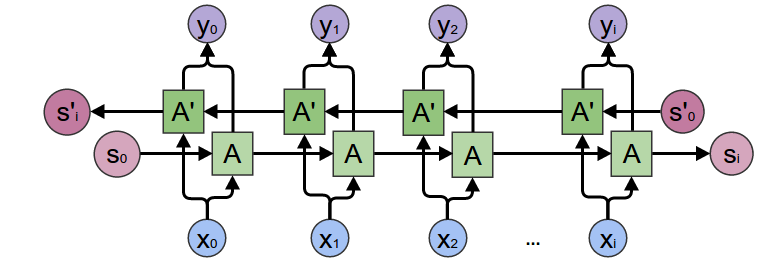

在每一个时间节点$x _ { t }$，这个网络有两层神经元，一层从左向右传播，另一层从右向左传播。为了保证任何时刻t都有两层隐层，这个网络需要消耗两倍的存储量来存储权重和偏置等参数。最终的分类结果是由两层RNN隐层组合来产生最终的结果。

公式1和2表示双向RNN隐层的数学含义。在这两个关系中唯一不同点是循环的方向不一样。公式3展示了通过总结过去和未来词的表示，使用类别的关系来预测下一个词预测。

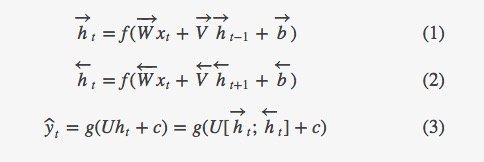

双向循环神经网络的基本思想是提出每一个训练序列向前和向后分别是两个循环神经网络，而且这两个都连接着一个输出层，这个结构提供给输出层输入序列中每个点的完整的过去和未来的上下文信息。

## 函数接口

在tensorflow中已经提供了双向RNN的接口，使用tf.nn.rnn.bidirectional_dynamic_rnn()这个函数，就可以很方便的构建双向RNN网络。
首先看下接口的一些参数：

bidirectional_dynamic_rnn(
    cell_fw, # 前向 rnn cell
    cell_bw, # 反向 rnn cell
    inputs, # 输入序列.
    sequence_length=None, # 输入序列的实际长度（可选，默认为输入序列的最大长度）
    initial_state_fw=None, # 前向rnn_cell的初始状态（可选）
    initial_state_bw=None, # 反向rnn_cell的初始状态（可选）
    dtype=None, # 初始化和输出的数据类型（可选）
    parallel_iterations=None,
    swap_memory=False,
    time_major=False,  # 决定了输入输出tensor的格式：如果为true, 向量的形状必须为 `[max_time, batch_size, depth]`. 
                       # 如果为false, tensor的形状必须为`[batch_size, max_time, depth]`. 与dynamic_rnn中的time_major类似。
    scope=None
)

函数的返回值：
一个（outputs, outputs_state）的一个元祖。
其中，outputs=(outputs_fw, outputs_bw),是一个包含前向cell输出tensor和后向tensor输出tensor组成的元祖。
若time_major=false，则两个tensor的shape为[batch_size, max_time, depth]，应用在文本中时，max_time可以为句子的长度（一般以最长的句子为准，短句需要做padding），depth为输入句子词向量的维度。最终的outputs需要使用tf.concat(outputs, 2)将两者合并起来。

outputs_state = (outputs_state_fw， output_state_bw),包含了前向和后向最后的隐藏状态的组成的元祖。outputs_state_fw和output_state_bw的类型都是LSTMStateTuple。LSTMStateTuple由(c, h)组成，分别代表memory cell和hidden state
cell_fw和cell_bw的定义是完全一样的，如果两个cell都定义成LSTM就变成说了双向LSTM了。

In [ ]:
import tensorflow as tf
#正向传播的rnn_cell单元，这里使用的是LSRTMCell
num_units=10
cell_fw_lstm = tf.nn.rnn_cell.LSTMCell(num_units)
#反向传播的rnn_cell单元，与正向传播的rnn单元相同
cell_bw_lstm = tf.nn.rnn_cell.LSTMCell(num_units)
(outputs, outputs_state) = tf.nn.bidirectional_dynamic_rnn(cell_fw_lstm, cell_bw_lstm, inputs_embedded)
#inputs_embedded为输入的tensor，[batch_szie, max_time, depth]。batch_size为模型当中batch的大小.
#应用在文本中时，max_time可以为句子的长度（一般以最长的句子为准，短句需要做padding），depth为输入句子词向量的维度。

最终的输出outputs = tf.concat((outputs_fw, outputs_bw), 2)或者直接是outputs = tf.concat(outputs, 2)

如果还需要用到最后的输出状态，则需要对（outputs_state_fw， output_state_bw）处理:

In [7]:
import tensorflow as tf
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

tf.reset_default_graph()
vocab_size = 1000
embedding_size = 50
batch_size =100
max_time = 10
hidden_units = 10

inputs = tf.placeholder(shape=(batch_size, max_time), dtype=tf.int32, name='inputs')
embedding = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0), dtype=tf.float32)
inputs_embeded = tf.nn.embedding_lookup(embedding, inputs)

lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(hidden_units)

((outputs_fw, outputs_bw), (outputs_state_fw, outputs_state_bw)) = tf.nn.bidirectional_dynamic_rnn(lstm_cell, lstm_cell, inputs_embeded,dtype=tf.float32)

outputs = tf.concat((outputs_fw, outputs_bw), 2)

final_state_c = tf.concat((outputs_state_fw.c, outputs_state_bw.c), 1)
final_state_h = tf.concat((outputs_state_fw.h, outputs_state_bw.h), 1)
outputs_final_state = tf.contrib.rnn.LSTMStateTuple(c=final_state_c,h=final_state_h)
print(final_state_c)
print(final_state_h)

Tensor("concat_1:0", shape=(100, 20), dtype=float32)
Tensor("concat_2:0", shape=(100, 20), dtype=float32)
